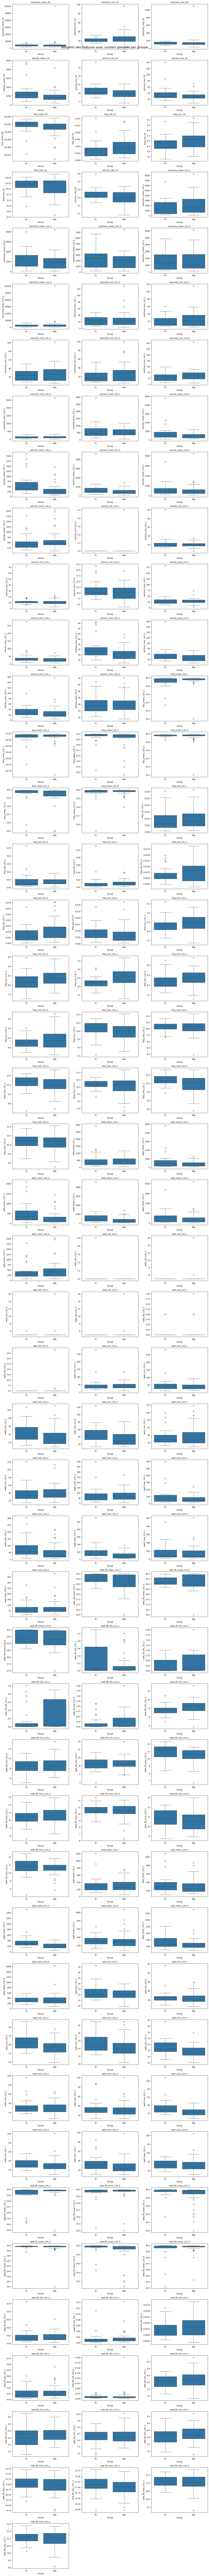

Nombre de features avec outliers détectées : 136
Features avec outliers : ['inactivity_mean_3d', 'inactivity_min_3d', 'inactivity_max_3d', 'activity_mean_3d', 'activity_min_3d', 'activity_max_3d', 'freq_mean_3d', 'freq_std_3d', 'freq_min_3d', 'freq_max_3d', 'activity_rate_3d', 'inactivity_mean_12h_1', 'inactivity_mean_12h_2', 'inactivity_mean_12h_4', 'inactivity_mean_12h_5', 'inactivity_mean_12h_6', 'inactivity_min_12h_2', 'inactivity_min_12h_3', 'inactivity_min_12h_4', 'inactivity_min_12h_5', 'inactivity_min_12h_6', 'inactivity_max_12h_6', 'activity_mean_12h_1', 'activity_mean_12h_2', 'activity_mean_12h_3', 'activity_mean_12h_4', 'activity_mean_12h_5', 'activity_mean_12h_6', 'activity_std_12h_4', 'activity_min_12h_1', 'activity_min_12h_2', 'activity_min_12h_4', 'activity_max_12h_1', 'activity_max_12h_2', 'activity_max_12h_3', 'activity_max_12h_4', 'activity_max_12h_5', 'activity_max_12h_6', 'freq_mean_12h_1', 'freq_mean_12h_2', 'freq_mean_12h_3', 'freq_mean_12h_4', 'freq_mean_12h_5', 

In [6]:
import os 
import pandas as pd 

DB_ROOT = "/home/ndecaux/NAS_EMPENN"
actimetry = pd.read_excel("/home/ndecaux/NAS_EMPENN/share/projects/actidep/bids/actimetry_features.xlsx")
participants = pd.read_excel("/home/ndecaux/NAS_EMPENN/share/projects/actidep/bids/participants_full_info.xlsx")
# actimetry = pd.read_excel(".../actimetry_features.xlsx")
# participants = pd.read_excel(".../participants_full_info.xlsx")
acti_prefixed = actimetry.rename(columns=lambda col: f"acti_{col}" if col != "participant_id" else col)
df = pd.merge(acti_prefixed, participants, on="participant_id", how="inner")

# Affiche les boxplots de chaque actimetry feature, en les groupant par 'group'
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import io
import base64
import hvplot.pandas

# Ensure hvplot uses the bokeh backend
hvplot.extension('bokeh')

# Generate boxplots for each actimetry feature grouped by 'group'
acti_features = [col for col in df.columns if col.startswith("acti_") and col != "participant_id"]
# Filter constant variables
acti_features_filtered = [feature for feature in acti_features if df[feature].std() > 0]

# Alternative method: Identify features with outliers using IQR method
features_with_outliers = []
for feature in acti_features_filtered:
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    # Check if there are outliers
    if any((df[feature] < lower_bound) | (df[feature] > upper_bound)):
        features_with_outliers.append(feature)

# Calculate grid dimensions for subplots
n_features = len(features_with_outliers)
n_cols = min(3, n_features)  # Maximum 3 columns
n_rows = (n_features + n_cols - 1) // n_cols  # Ceiling division

# Create subplots grid
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
fig.suptitle('Boxplots des features avec outliers groupés par groupe', fontsize=16, y=0.98)

# Handle case where there's only one subplot
if n_features == 1:
    axes = [axes]
elif n_rows == 1:
    axes = axes.reshape(1, -1)

# Plot each feature
for i, feature in enumerate(features_with_outliers):
    row = i // n_cols
    col = i % n_cols
    ax = axes[row, col] if n_rows > 1 else axes[col]
    
    sns.boxplot(data=df, x='group', y=feature, ax=ax)
    ax.set_title(f"{feature.replace('acti_', '')}", fontsize=10)
    ax.set_xlabel('Group')
    ax.set_ylabel(feature.replace('acti_', ''))

# Hide empty subplots
for i in range(n_features, n_rows * n_cols):
    row = i // n_cols
    col = i % n_cols
    ax = axes[row, col] if n_rows > 1 else axes[col]
    ax.set_visible(False)

plt.tight_layout()
plt.show()

print(f"Nombre de features avec outliers détectées : {len(features_with_outliers)}")
print(f"Features avec outliers : {[f.replace('acti_', '') for f in features_with_outliers]}")